In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
my_dir = '/content/drive/My Drive/My Projects/'
os.chdir(my_dir)

In [3]:
import pandas as pd
file_path = 'IMDB Dataset.csv'
df = pd.read_csv(file_path)
df = df.sample(frac=1).reset_index(drop=True)
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [4]:
MAX_SEQ_LEN = 800
EMBEDDING_DIM = 100

In [5]:
import numpy as np
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_tags, strip_multiple_whitespaces, strip_numeric, strip_non_alphanum, remove_stopwords, stem_text
from joblib import Parallel, delayed
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential

In [6]:
filters = [lambda x: x.lower(), strip_tags, stem_text, strip_punctuation, strip_numeric, strip_non_alphanum]
def process_text(text):
  text = remove_stopwords(text)
  text = preprocess_string(text, filters)
  text = ' '.join(ch for ch in text)
  return text

In [7]:
train = df[:40000]

In [8]:
processed_texts = Parallel(n_jobs=2, backend='multiprocessing')(
    delayed(process_text)(text) for i, text in tqdm(enumerate(train['review']), total=len(train)))

100%|██████████| 40000/40000 [00:33<00:00, 1188.32it/s]


In [9]:
def tokenize(texts):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(texts)
  seq = tokenizer.texts_to_sequences(texts)
  word_index = tokenizer.word_index
  seq = pad_sequences(seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
  return word_index, seq, tokenizer

In [10]:
word_index, sequences, tokenizer = tokenize(processed_texts)

In [11]:
def prep_test(data, tokenizer):
  texts = Parallel(n_jobs=2, backend='multiprocessing')(
    delayed(process_text)(text) for i, text in tqdm(enumerate(data['review']), total=len(data)))
  seq = tokenizer.texts_to_sequences(texts)
  seq = pad_sequences(seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
  return seq

In [12]:
train_y = train['label']

In [13]:
test_x = prep_test(df[40000:], tokenizer)
test_y = df[40000:]['label']

100%|██████████| 10000/10000 [00:08<00:00, 1218.21it/s]


In [14]:
def prep_embeddings(word_index):
  glove_file = my_dir+'glove.6B.100d.txt'
  embeddings_index = dict()
  with open(glove_file) as file:
    for line in file:
      values = line.split()
      word = values[0]
      embeddings_index[word] = np.asarray(values[1:], dtype=np.float32)
  embeddings_matrix = np.random.random((len(word_index)+1, EMBEDDING_DIM))
  for word, i in word_index.items():
    vec = embeddings_index.get(word)
    if vec is not None:
      embeddings_matrix[i] = vec
  return embeddings_matrix

In [15]:
embeddings_matrix = prep_embeddings(word_index)

In [16]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5)

In [17]:
model = Sequential([
                    Input(shape=(MAX_SEQ_LEN,)),
                    Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embeddings_matrix], trainable=False, input_length=MAX_SEQ_LEN),
                    CuDNNGRU(128, return_sequences=True),
                    GlobalMaxPool1D(),
                    Dropout(0.25),
                    Dense(128, activation='relu'),
                    Dropout(0.25),
                    Dense(1, activation='sigmoid')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 800, 100)          9045400   
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (None, 800, 128)          88320     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(sequences, train_y, epochs=50, batch_size=64, steps_per_epoch=625, validation_data=(test_x, test_y), validation_steps=157, callbacks=[early_stopping])

Epoch 1/50
625/625 [==============================] - 43s 68ms/step - loss: 0.4977 - accuracy: 0.7492 - val_loss: 0.3948 - val_accuracy: 0.8211
Epoch 2/50
625/625 [==============================] - 40s 65ms/step - loss: 0.3862 - accuracy: 0.8272 - val_loss: 0.3771 - val_accuracy: 0.8319
Epoch 3/50
625/625 [==============================] - 40s 65ms/step - loss: 0.3526 - accuracy: 0.8457 - val_loss: 0.3387 - val_accuracy: 0.8557
Epoch 4/50
625/625 [==============================] - 40s 65ms/step - loss: 0.3253 - accuracy: 0.8581 - val_loss: 0.3398 - val_accuracy: 0.8447
Epoch 5/50
625/625 [==============================] - 41s 65ms/step - loss: 0.3046 - accuracy: 0.8718 - val_loss: 0.3219 - val_accuracy: 0.8615
Epoch 6/50
625/625 [==============================] - 41s 66ms/step - loss: 0.2890 - accuracy: 0.8778 - val_loss: 0.3191 - val_accuracy: 0.8589
Epoch 7/50
625/625 [==============================] - 41s 66ms/step - loss: 0.2712 - accuracy: 0.8866 - val_loss: 0.3458 - val_accuracy:

In [ ]:
sequences.shape, train_y.shape

((40000, 300), (40000,))

In [21]:
import matplotlib.pyplot as plt


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

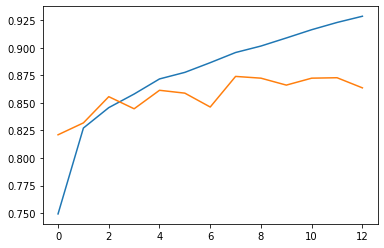

In [23]:
plt.plot(range(len(history.epoch)), history.history['accuracy'], range(len(history.epoch)), history.history['val_accuracy'])
plt.show()